## 3_cross-species  -  Train, Evaluation, and Calculate ISM

In this tutorial, we demonstrate how to perform prediction and evaluation on cross-species data. We train XChrom using samples from one species and evaluate the model on samples from another species, showcasing the model's performance across different biological systems (effectively covering two dimensions: cross-sample and cross-species prediction).

We use a publicly available single-cell multiome dataset collected from the motor cortex of human, macaque, marmoset, and mouse. Each species contains multiple samples. In addition to providing raw sequencing data, the authors also offer pre-processed and cell-annotated scRNA data for each sample. We extracted paired data and assigned the annotated cell types to obtain the raw dataset for this study. We then integrated scRNA data from different samples within each species using Harmony, and finally performed cross-species integration based on 1-to-1 orthologous genes. The resulting batch-corrected cell embeddings are stored in `RNA.obsm['X_pca_harmony']`. The processed scRNA and scATAC paired data (after filtering and batch correction) have been uploaded to **Zenodo [link]**. For detailed procedures, please refer to **XChrom_analysis [link]**.

- **Data Preprocessing**  
As an example, we extract two samples from human and mouse respectively, labeled `m1d1` and `mop3c2`. In this tutorial, we use mouse (`mop3c2`) as the training set and human (`m1d1`) as the test set. For the training scATAC data, we split it by cells and peaks to generate training/validation data for model training, following the same procedure as in the `1_within-sample` tutorial to create model inputs. For the test scATAC data, we use the entire test set for evaluation. For the scRNA data, we directly use the processed batch-corrected cell embeddings (`RNA.obsm['X_pca_harmony']`) as input for model training and prediction.

- **Model Training**  
During training, the model takes as input sequences (one-hot encoded, 1 × seq_len) and cell embeddings (a cells × embedding_dimensions array) to predict sequence accessibility across cells. Note that the raw cell embeddings here are derived from batch-corrected scRNA data of both samples.

- **Prediction and Evaluation**  
After training, we evaluate the model's ability to predict chromatin accessibility in the processed test sample. Evaluation is conducted from two perspectives:
  - Using **auROC and auPRC** to assess the accuracy of cross-species predictions.
  - Using **neighbor score (NS)** and **label score (LS)** to evaluate cross-modality neighborhood consistency and the consistency of cell labels within local neighborhoods in the cross-species scenario.

This comprehensive evaluation demonstrates the model's capability to generalize across species boundaries while maintaining biological meaningfulness in its predictions.

### 1. Download Data (Human: m1d1, Mouse: mop3c2)

- The original data is available at [GEO accession GSE229169](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE229169). We have processed this data by performing batch correction using orthologous genes to generate raw cell embeddings for each sample as model inputs. The data has been filtered (filtering threshold: 0.01) and is available for direct download on **Zenodo**. For this tutorial, we use only the human sample m1d1 and the mouse sample mop3c2 as examples, training XChrom on the mouse data and performing prediction on the human data.
- Download the human sample files:
  - `m1d1_atac.h5ad` and save to `'./data/3_cross_species/m1d1_atac.h5ad'`
  - `m1d1_rna_harmony.h5ad` and save to `'./data/3_cross_species/m1d1_rna_harmony.h5ad'`
- Download the mouse sample files:
  - `mop3c2_atac.h5ad` and save to `'./data/3_cross_species/mop3c2_atac.h5ad'`
  - `mop3c2_rna_harmony.h5ad` and save to `'./data/3_cross_species/mop3c2_rna_harmony.h5ad'`
- Download the human genome file from:
  [https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz](https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz)
  and decompress it.
- Download the mouse genome file from:
  [https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.fa.gz](https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.fa.gz)
  and decompress it.
- If needed, genomes for other species are also available:
  - Macaque (* M. mulatta (rhesus monkey): Mmul_10 (rheMac10)Macaca mulatta*)
  - Marmoset (*Cal Callithrix jacchus (white-tufted-ear marmoset): cj1700_1.1 (calJac4)lithrix jacchus*)
- The raw cell embeddings are stored in `RNA.obsm['X_pca_harmony']`, and cell type labels are available in `RNA.obs['cell_type']` for use as ground truth labels.

In [1]:
import scanpy as sc
import xchrom as xc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 2.Read and filter data

Indeed, the data we have uploaded to the **Zenodo link** has already undergone comprehensive filtering and preprocessing. So you can ignore this filter data process actually.

It is crucial that the `species` parameter correctly corresponds to the species of your input data. This parameter is used to filter out sequences located on chromosomes not belonging to the specified species (e.g., retaining only chr1-22, X, Y for human data, or chr1-19, X, Y for mouse data). 

After this filtering step is completed, the resulting AnnData object for the ATAC data will contain the `ATAC.obs['n_genes']` field. This field, which represents the number of peaks detected per cell, is automatically utilized during the generation of input data for model training.

In [2]:
mop3c2_rna = sc.read_h5ad('./data/3_cross_species/mop3c2_rna_harmony.h5ad')
mop3c2_atac = sc.read_h5ad('./data/3_cross_species/mop3c2_atac.h5ad')
_, mop3c2_atac = xc.pp.filter_multiome_data(
    ad_rna = mop3c2_rna,
    ad_atac = mop3c2_atac,
    species = 'mouse',
    filter_ratio = 0
)

RNA data after filtering: View of AnnData object with n_obs × n_vars = 6668 × 1193
    obs: 'cell_type', 'n_genes', 'sampleID', 'species', 'batch'
    var: 'feature_types', 'ortho_h_id', 'ortho_h_names', 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sampleID_colors', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'zscore32_perpc'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
ATAC data after filtering: View of AnnData object with n_obs × n_vars = 6668 × 107451
    obs: 'cell_type', 'n_genes'
    var: 'ids', 'names', 'feature_types', 'chr', 'start', 'end', 'n_cells'


In [3]:
### filter data
m1d1_rna = sc.read_h5ad('./data/3_cross_species/m1d1_rna_harmony.h5ad')
m1d1_atac = sc.read_h5ad('./data/3_cross_species/m1d1_atac.h5ad')
_, m1d1_atac = xc.pp.filter_multiome_data(
    ad_rna = m1d1_rna,
    ad_atac = m1d1_atac,
    species = 'human',
    filter_ratio = 0
)

RNA data after filtering: View of AnnData object with n_obs × n_vars = 4489 × 1193
    obs: 'cell_type', 'n_genes', 'sampleID', 'species', 'batch'
    var: 'feature_types', 'ortho_h_id', 'ortho_h_names', 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sampleID_colors', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
ATAC data after filtering: View of AnnData object with n_obs × n_vars = 4489 × 37363
    obs: 'cell_type', 'n_genes'
    var: 'ids', 'names', 'feature_types', 'chr', 'start', 'end', 'n_cells'


In [4]:
m1d1_atac.write('./data/3_cross_species/m1d1_atac.h5ad')
mop3c2_atac.write('./data/3_cross_species/mop3c2_atac.h5ad')

### 3. Train/test data prepare

In [5]:
## generate data for model training
train_folder = './data/3_cross_species/train_data/'
input_fasta = '/picb/bigdata/project/miaoyuanyuan/mm10.fa'
train_atac = sc.read_h5ad('./data/3_cross_species/mop3c2_atac.h5ad')
dict = xc.pp.process_train_test_single(
    ad_atac=train_atac, ## can be a str, Path, or anndata.AnnData object
    input_fasta=input_fasta,
    output_path=train_folder
)

train/test data is saved in:  data/3_cross_species/train_data
successful writing bed file.
successful writing train/test split file.
successful writing train/test anndata file.
successful writing sparse m.
Successfully saving all sequence h5 file...
Successfully saving trainval sequence h5 file...
Successfully saving test sequence h5 file...


In [6]:
## generate data for model evaluation
test_folder = './data/3_cross_species/test_data/'
test_atac = sc.read_h5ad('./data/3_cross_species/m1d1_atac.h5ad')
input_fasta = '/picb/bigdata/project/miaoyuanyuan/hg38.fa'
dict = xc.pp.process_test_dual(
    ad_atac=test_atac, ## can be a str, Path, or anndata.AnnData object
    input_fasta=input_fasta,
    output_path=test_folder
)

train/test data is saved in:  data/3_cross_species/test_data
successful writing bed file.
successful writing sparse m.
start saving all sequence h5 file...


We performed preprocessing on the filtered scATAC data of human (m1d1) and mouse (mop3c2) samples separately:

**For the mop3c2 mouse training sample:**
Following the same procedure as in the `1_Within-sample` tutorial, we partitioned the data using 90% of cells and 90% of peaks to generate training/validation sets. This produced:
- `ad_trainval.h5ad`: containing training cells and training peaks
- `m_trainval.npz`: corresponding count matrix
- `trainval_seqs.h5`: base sequence file for training peaks

All files were saved in `'./data/3_cross_species/train_data/'`.

**For the m1d1 human test sample:**
No partitioning was applied. The filtered scATAC data was directly converted into the required model input files:
- `ad.h5ad`
- `m.npz`
- `all_seqs.h5`

These files were saved in `'./data/3_cross_species/test_data/'`.

Note: The `input_fasta` parameter should be replaced with the path to the genome file corresponding to the species used in your specific dataset.

### 4. Train XChrom

We use the preprocessed data from the mouse (mop3c2) training set obtained above as sequence inputs for the model. The `input_folder` should contain all files generated during preprocessing. The batch-corrected `X_pca_harmony` embeddings derived from scRNA data are used as raw cell embeddings and serve as cell identity inputs to the model. If using dimensionality reduction results from other methods, they must be stored in `cell_embedding_ad.obsm` under the key `cellembed_raw` for extraction.

If you wish to compute NS and LS for model parameters at every training epoch, you need to set `trackscore = True` and specify the cell type in either the RNA or ATAC H5AD file. When `print_scores = True` is specified, the computed NS and LS values will be printed during each training epoch. The model is set to train for 1000 epochs by default, but an early stopping mechanism will be triggered if the increase in training auROC remains below 1e-6 for 50 consecutive epochs. The `save_freq` parameter determines the frequency of saving model parameters, with a default value of 1000 (meaning intermediate model parameters are not saved during training).

In [7]:
history = xc.tr.train_XChrom(
    input_folder='./data/3_cross_species/train_data/',
    cell_embedding_ad='./data/3_cross_species/mop3c2_rna_harmony.h5ad',
    cellembed_raw='X_pca_harmony',
    out_path='./data/3_cross_species/train_out/',
    epochs = 1000,
    trackscore = True,
    print_scores = True,
    celltype = 'cell_type',
    verbose = 1
)

=== Start training XChrom model ===
Input folder: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/3_cross_species/train_data
Cell embedding file: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/3_cross_species/mop3c2_rna_harmony.h5ad
Raw cell embedding key: X_pca_harmony
Output path: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/3_cross_species/train_out
Model parameters: bottleneck=32, batch_size=128, lr=0.01
1. Load raw cell embedding and make z-score normalization...
Raw cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/3_cross_species/mop3c2_rna_harmony.h5ad.obsm['X_pca_harmony']
Initial cell embedding saved to: /picb/bigdata/project/miaoyuanyuan/train/XChrom_test/XChrom/source/Tutorials/data/3_cross_species/mop3c2_rna_harmony.h5ad.obsm['zscore32_perpc']
Initial cell embedding shape: (6668, 32)
2. Load training data...
3. P

2025-08-18 10:30:14.683558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-18 10:30:16.403718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17996 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:31:00.0, compute capability: 8.6
2025-08-18 10:30:16.404799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19873 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:4b:00.0, compute capability: 8.6
2025-08-18 10:30:16.405349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:l

5. Build and compile model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1344, 4)]    0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1344, 4), () 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1344, 4)      0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
gelu (GELU)                     (None, 1344, 4)      0           stochastic_shift[0][0]           
________________________________________________________________

2025-08-18 10:30:23.501891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-08-18 10:30:27.890841: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8800
2025-08-18 10:30:27.969441: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


680/680 [==============================] - 168s 232ms/step - loss: 0.3234 - binary_accuracy: 0.8749 - auc: 0.7746 - pr: 0.3225 - val_loss: 0.3126 - val_binary_accuracy: 0.8760 - val_auc: 0.7962 - val_pr: 0.3724
Neighbors Score: 0.2596, Labels Score: 0.6347 	Using time in epoch 1: 40.7640s
Epoch 2/1000
680/680 [==============================] - 159s 229ms/step - loss: 0.3116 - binary_accuracy: 0.8781 - auc: 0.7914 - pr: 0.3629 - val_loss: 0.3117 - val_binary_accuracy: 0.8765 - val_auc: 0.7977 - val_pr: 0.3809
Neighbors Score: 0.2772, Labels Score: 0.6639 	Using time in epoch 2: 35.7925s
Epoch 3/1000
680/680 [==============================] - 162s 234ms/step - loss: 0.3099 - binary_accuracy: 0.8787 - auc: 0.7944 - pr: 0.3697 - val_loss: 0.3105 - val_binary_accuracy: 0.8780 - val_auc: 0.7988 - val_pr: 0.3842
Neighbors Score: 0.2904, Labels Score: 0.6946 	Using time in epoch 3: 32.6157s
Epoch 4/1000
680/680 [==============================] - 162s 236ms/step - loss: 0.3089 - binary_accuracy

Plotting training metrics helps monitor overfitting and evaluate the final model performance. Ideally, after a certain number of epochs, the metric curves should stabilize and remain steady.

The metrics computed during training are saved in `./data/3_cross_species/train_out/history.pickle`. They can be loaded using the following code:

```python
import pickle

with open('./data/3_cross_species/train_out/history.pickle', 'rb') as f:
    history = pickle.load(f)
```

This `history` object contains all training metrics (loss, auROC, auPRC, etc.) recorded during the training process, which can be used to generate plots and analyze model performance.  

The function `plot_train_history()` will automatically detect whether NS and LS values have been computed during training. If these metrics are available in the history data, they will be automatically included in the training metric plots along with other evaluation metrics such as loss, auROC, and auPRC. 

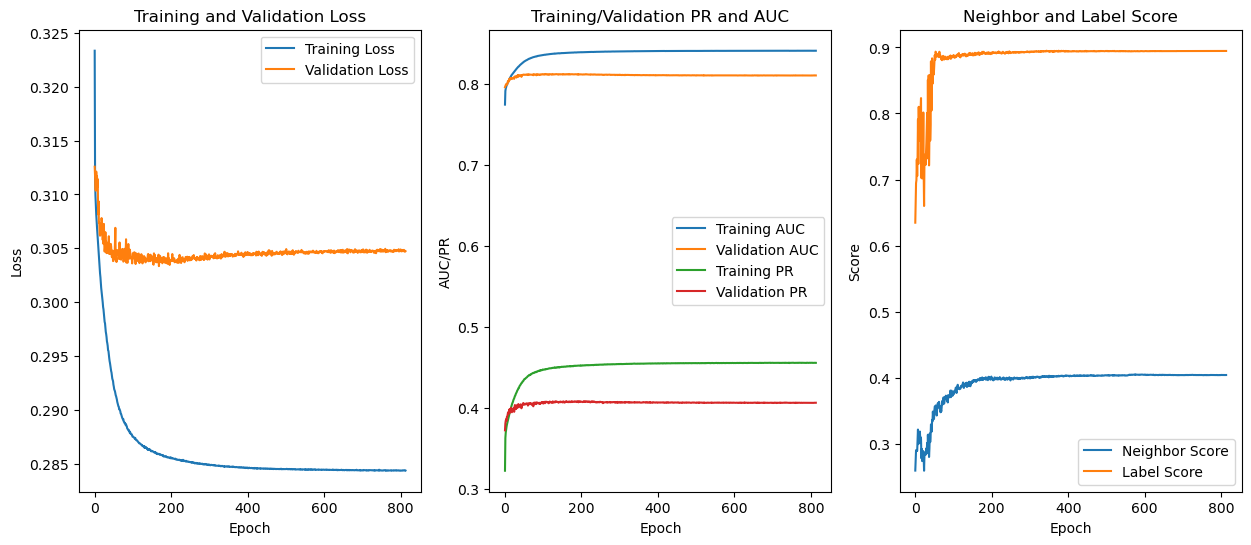

In [8]:
xc.pl.plot_train_history(
    history = history['history'],
    savefig = True,
    out_file = './data/3_cross_species/train_out/train_history_plot.pdf'
    )

### 5. Evaluate model performance in cross-species scenario

The following metrics will be evaluated on the **human(m1d1) test set data**:

*   **Prediction Accuracy**:
    Evaluation of cross-sample prediction accuracy using:
    *   **auROC** (Area Under the Receiver Operating Characteristic curve)
    *   **auPRC** (Area Under the Precision-Recall curve)

*   **Cross-Modality Neighborhood Consistency and Cell Label Consistency**:
    Assessment of cross-modality neighborhood consistency and cell label consistency in the cross-sample scenario using:
    *   **Neighbor Score (NS)**: Quantifies the percentage of overlapping neighbors between independently constructed nearest-neighbor graphs built from scRNA data (`'X_pca'` or `'X_pca_harmony'`) and scATAC data.
    *   **Label Score (LS)**: Measures the percentage of a cell's neighbors that share the same cell-type label within a given nearest-neighbor graph. The provided cell type annotations will be used directly as labels for LS calculation.

This combined approach of quantitative accuracy metrics (auROC/auPRC) and biological consistency metrics (NS/LS based on true labels) provides a comprehensive evaluation of the model's predictive performance on data from different species.

The evaluation will help validate the model's capability to handle batch effects during cross-sample prediction while maintaining biological meaningfulness. Assessment will be conducted at multiple neighborhood scales (e.g., k=100, 50, 10) to examine consistency across different resolutions.

2025-08-20 14:08:32.946716: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-20 14:08:34.542231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19982 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:31:00.0, compute capability: 8.6
2025-08-20 14:08:34.542839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21971 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:4b:00.0, compute capability: 8.6
2025-08-20 14:08:34.543350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:l

Predict done! prediction shape is: (37363, 4489)
Overall auROC: 0.7519, auPRC: 0.3469
Per-cell auROC: 0.6918, auPRC: 0.2696
Valid cells: 4489
Per-peak auROC: 0.6965, auPRC: 0.2516
Valid peaks: 37363


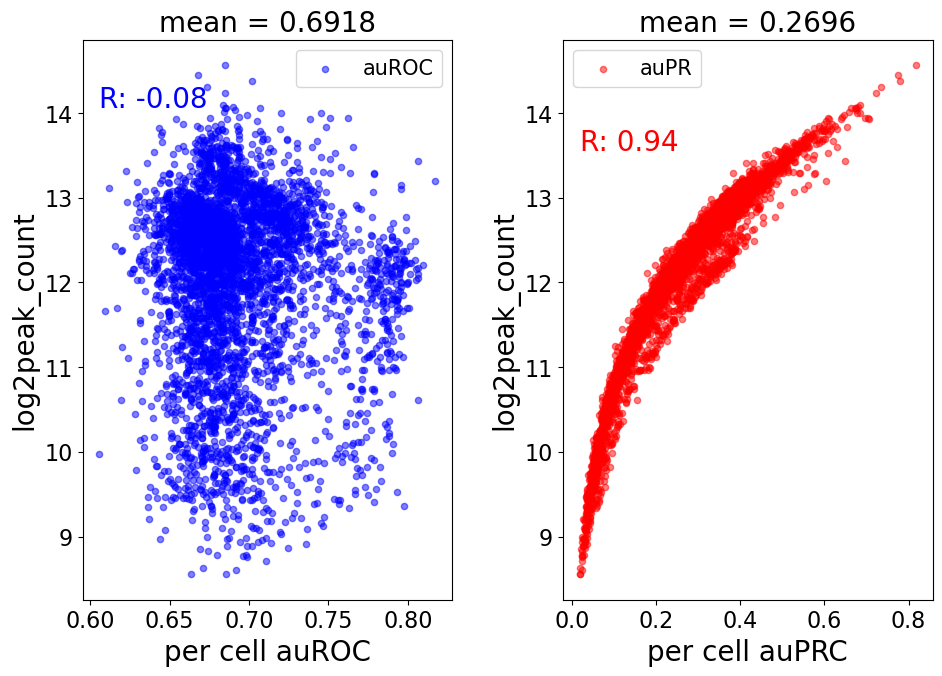

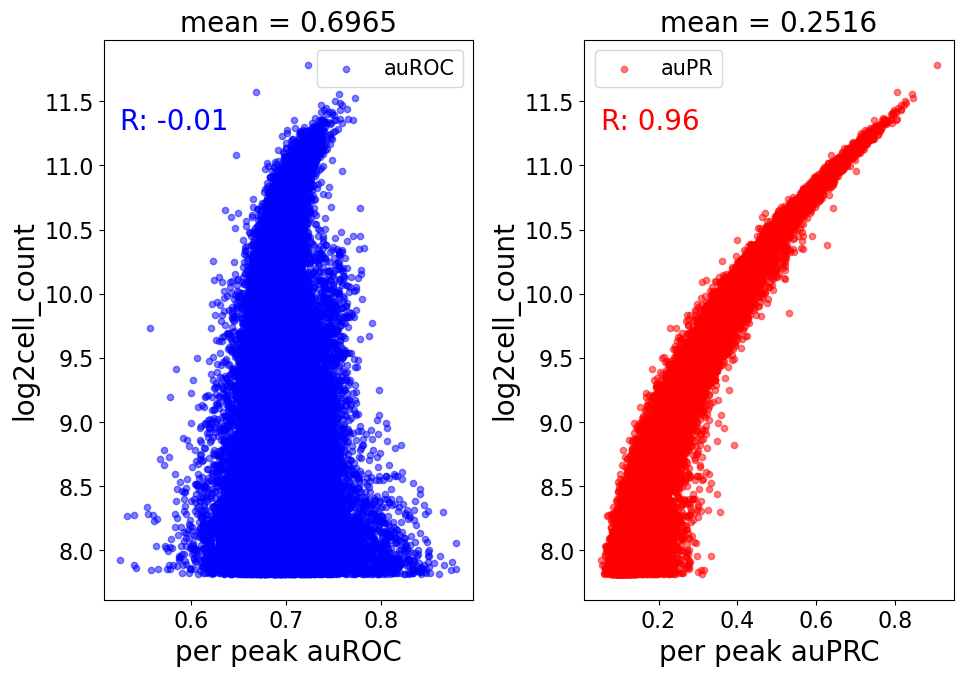

In [9]:
#### 1- calculate cross-species auROC & auPRC
metrics1 = xc.tl.crosssamples_aucprc(
    cell_embedding_ad='./data/3_cross_species/m1d1_rna_harmony.h5ad',
    input_folder='./data/3_cross_species/test_data',
    model_path='./data/3_cross_species/train_out/E1000best_model.h5',
    output_path='./data/3_cross_species/eval_out',
    cellembed_raw='X_pca_harmony',
    save_pred=True,
    scatter_plot=True
    )

Predict done! prediction shape is: (37363, 4489)


/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


neighbor score(100)=0.2347,label score(100)=0.8496
neighbor score(50)=0.1708,label score(50)=0.8776
neighbor score(10)=0.0772,label score(10)=0.9098


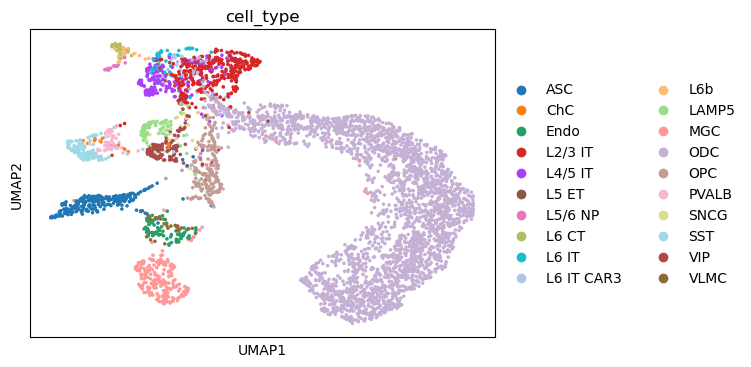

In [10]:
#### 2- calculate cross-species ns & ls
metrics2 = xc.tl.crosssamples_nsls(
    cell_embedding_ad='./data/3_cross_species/m1d1_rna_harmony.h5ad',
    input_folder='./data/3_cross_species/test_data',
    model_path='./data/3_cross_species/train_out/E1000best_model.h5',
    output_path='./data/3_cross_species/eval_out',
    cellembed_raw='X_pca_harmony',
    celltype = 'cell_type',
    save_pred=True,
    plot_umap=True
    )

### 6. Calculate ISM

We performed in **silico saturation mutagenesis (ISM)** for input sequence, in which we predicted the change in accessibility in every cell after mutating each position to its three alternative nucleotides. For each mutation, we compared the alternative accessibility prediction to that of the reference to compute the change in accessibility for each cell. We normalized the ISM scores for the four nucleotides at each position such that they summed to zero. We then took the normalized ISM score at the reference nucleotide as the importance score for that position to plot.

In [11]:
m1d1_rna = sc.read_h5ad('./data/3_cross_species/m1d1_rna_harmony.h5ad')
model = xc.tr.XChrom_model(n_cells=m1d1_rna.shape[0],show_summary=False)
model.load_weights('./data/3_cross_species/train_out/E1000best_model.h5')

ism_results = xc.tl.calc_ism_from_bed(
    cell_embedding_ad = m1d1_rna,
    cellembed_raw = 'X_pca_harmony',
    peak_bed='./data/3_cross_species/m1d1_peaks.bed',
    fasta_file='/picb/bigdata/project/miaoyuanyuan/hg38.fa',
    XChrom_model = model,
    output_path='./data/3_cross_species/ISM_results/'
)
print(f"ISM matrix shape: {ism_results[0].shape}")

Extracting sequences from BED file...
Converting to one-hot encoding...
Calculating ISM for 1 peaks...
Processing peak 1/1
All ISM matrices shape (n_peaks, n_cells, seq_len, 4): (1, 4489, 1344, 4)
ISM calculation completed. Results saved to ./data/3_cross_species/ISM_results/
ISM matrix shape: (4489, 1344, 4)


In [12]:
peak0_ism = np.load('./data/3_cross_species/ISM_results/peak0_ism.npy')
tmp,seqs_coords = xc.tl.ism_norm(
    peak_ism = peak0_ism,
    peak_bed = './data/3_cross_species/m1d1_peaks.bed',
    fasta_file='/picb/bigdata/project/miaoyuanyuan/hg38.fa',
    seq_len=1344)

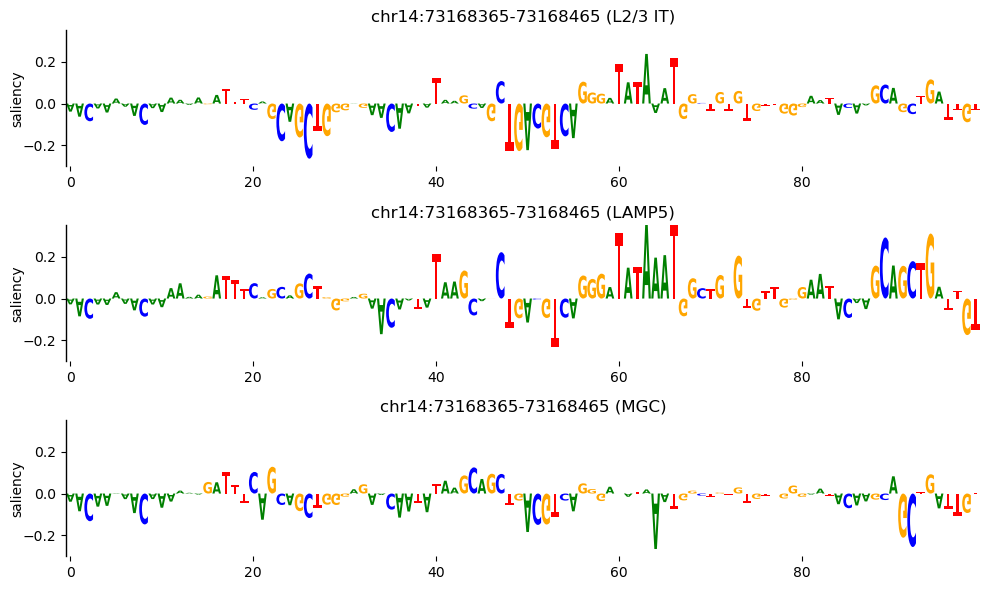

In [13]:
ad = sc.read_h5ad('./data/3_cross_species/m1d1_atac.h5ad')
cts = ['L2/3 IT','LAMP5','MGC']
f, axs = plt.subplots(nrows=3, figsize=(10, 6))
a = 510	
b = 610
for i in range(3):
    # aggregate cells
    cells = np.where((ad.obs['cell_type']==cts[i]))[0] 
    # normalize
    toplot = pd.DataFrame(tmp[cells,:].mean(axis=0), columns = ['A', 'C', 'G', 'T']) 
    toplot = toplot.iloc[a:b,:]  
    toplot.index = np.arange(toplot.shape[0])  
    xc.pl.plot_logo(toplot, -0.3,0.35, axs[i], '%s:%d-%d (%s)'%(seqs_coords[0][0],seqs_coords[0][1]+a, seqs_coords[0][1]+b, cts[i]))
f.tight_layout()
# f.savefig('./ism_peak0_100bp_celltype3.pdf', bbox_inches='tight', dpi=300,format="pdf")

### 7. Calculate PWM-ISM dot product

After obtaining the base-level importance scores for each input sequence, we sought to determine whether specific motifs play key roles in model training and prediction for particular cell types. We scanned these sequences (using the FIMO tool) to identify candidate motifs and then calculated whether the PWM scores of these candidate motifs correlated with the ISM values computed for the region. A correlation value was obtained for each cell, and the final result was derived by averaging these values across all cells of the same cell type. The specific analysis code can be found via **XChrom_analysis**.

Here, we only show tge correlation values between the PWM score of motif MEF2C and the ISM values computed for the candidate MEF2C region identified at chr14:73168099-73168956 (in m1d1_peaks.bed) for three cell types: 'L2/3 IT', 'LAMP5', and 'MGC'.

In [14]:
ism = np.load('./data/3_cross_species/ISM_results/peak0_ism.npy')
ism_norm = ism - np.repeat(ism.mean(axis=2)[:,:,np.newaxis],4,axis=2)
motif = 'MEF2C'
pwm = pd.read_csv(f'./data/3_cross_species/{motif}.csv',index_col = 0)
start_site = 566
ism_matrix = ism_norm[:,start_site:(start_site+pwm.shape[1]),:]
m1d1_rna.obs[motif] = [np.dot(pwm.transpose().values.flatten(),i.flatten()) for i in ism_matrix]

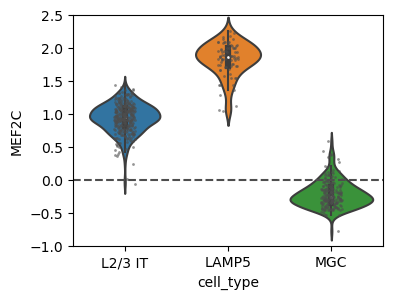

In [15]:
cts = ['L2/3 IT','LAMP5','MGC']
f, axs = plt.subplots(ncols=1, figsize=(4,3))
sns.violinplot(x='cell_type', y = motif, data=m1d1_rna.obs, order=cts)
sns.stripplot(x='cell_type', y=motif, data=m1d1_rna.obs, order=cts, alpha=0.6, color='0.3', size=2)
axs.set_ylim(-1,2.5)
axs.axhline(y=0, linestyle='dashed', color='0.3')
# f.savefig(f'./corr_{motif}.pdf', bbox_inches='tight', dpi=300)

The differential signals of MEF2C in L2/3 IT (excitatory neurons), LAMP5 (inhibitory neurons), and MGC (non-neuronal cells). The vertical axis represents the computed MEF2C PWM-ISM correlation (dot product) described above.

The bar plot visualizes the average correlation value between the Position Weight Matrix (PWM) score for the MEF2C motif and the Importance Score Matrix (ISM) values within the candidate genomic region (chr14:73168099-73168956) for each cell type. A higher correlation suggests the model has learned that the MEF2C binding motif is a stronger predictive feature for chromatin accessibility in that specific cell type.

The results indicate that the MEF2C motif has the strongest association with the model's predictions in the excitatory neurons (L2/3 IT), a weaker association in the inhibitory neurons (LAMP5), and the weakest association in the non-neuronal cells (MGC), which aligns with the known sequence accessibility signal in scATAC.